In [1]:
import pandas as pd
import numpy as np
import urllib.request as ur
import urllib.parse   as up
import json

#Получим информацию о имени группы, статусе и описании с помощью API
#Кажется надо брать еще несколько постов со стены через wall.get 
#https://vk.com/dev/wall.get?params[owner_id]=-26270763&params[count]=10&params[filter]=owner
def get_description(vk_id):
    params = up.urlencode({'group_ids': vk_id, 'fields': 'status,description'})
    url="https://api.vk.com/method/groups.getById?%s" % params
    response = ur.urlopen(url)
    group_description = response.read().decode('utf-8')
    group_description = json.loads(group_description)['response'][0]
    res={'id': vk_id, 'name': '', 'status': '', 'description': '' }
    
    #If banned
    if ('deactivated' in group_description):
        return res
    
    #If very closed group or group is an event
    if (group_description['is_closed'] > 1 or group_description['type'] == "event"):
        return res
    
    res['name'] = group_description['name']
    res['status'] = group_description['status']
    res['description'] = group_description['description'].replace("<br>", " ")
    return res

#group_data = pd.DataFrame({"id": np.array([10,20,30,40,50])}, columns=['id', 'name', 'status', 'description'] )
#print (group_data)

In [2]:
groip_id = np.loadtxt("spb_community_stats.csv", dtype=np.int64)

In [45]:
first_time=False
n_samples = 20000

#np.random.seed(122)
#groip_id_small = np.random.choice(groip_id, size=1000)

In [46]:
if (first_time):
    group_data = pd.DataFrame({"id": groip_id}, columns=['id', 'name', 'status', 'description'])
    for i in group_data["id"].iteritems():
        group_data.iloc[i[0]] = pd.DataFrame.from_dict(get_description(i[1]), orient='index').T.loc[0]
    group_data.to_pickle('group_data.pkl')
else:
    group_data = pd.read_pickle('group_data.pkl')
    group_data = group_data.loc[:n_samples]

In [47]:
#from nltk.tokenize import RegexpTokenizer
import re

#group_data_tmp = group_data.copy()

#Simplify work with list objects
def apply_to_data(self, func):
    columns = ['name', 'status', 'description']
    for c in columns:
        self[c]=self[c].apply(func)
pd.DataFrame.apply_to_data =  apply_to_data  

#Tokenize text
pattern = r'[A-Za-z\u0400-\u0451]+' #include latin and cyrillic letters (UNICODE)
regexcomp = re.compile(pattern, flags = re.UNICODE | re.MULTILINE | re.DOTALL)
tokenizer_re = lambda s: regexcomp.findall(s)
toc_vec = np.vectorize(tokenizer_re, otypes=[np.chararray])
#group_data_tmp.apply_to_data( toc_vec )

#All words to lowercase
lower_list = lambda x: np.char.asarray([item.lower() for item in x])
#group_data_tmp.apply_to_data( lower_list )


#Remove short words (L<=2) and stop words
from nltk.corpus import stopwords
#Создадим свой список, будем добавлять сюда новые слова, которые будут выявляться в процессе выделения тематики
#Cсылки слишком много мусорят, надо что-то делать
custum_stop = ['ваш', 'наш', 'этот', 'тот', 'который', 'группа', 'клуб', 'свой', 'каждый', 'самый', 'твой',  \
               'www', 'http', 'https', 'html', 'org', 'ru', 'com', 'php', 'amp','club', 'group', 'vkontakte',\
               'страница', 'сайт', 'вконтакте', 'закрытый', 'официальный', 'сообщество', 'паблик', 'стена',  \
               'публиковать', 'подписаться',  'комментарий', 'подписчик', 'правило', \
               'official', 'public', 'instagram', 'twitter', 'facebook', 'youtube', 'mail', 'gmail', 'livejournal']
rm_short = lambda x: np.char.asarray([ item for item in x if (len(item) > 2 and \
                                           not item in stopwords.words('english') and \
                                           not item in stopwords.words('russian') and \
                                           not item in custum_stop)])
#group_data_tmp.apply_to_data( rm_short) 



import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def get_normal_form(word):
    global morph
    value_forms = ['NOUN', 'ADJF', 'VERB', 'INFN', 'LATN'] #существительные, прилагательные, глаголы и латинские
    try: 
        p = morph.parse(word)[0] #We will take only first normal form
        if (str(p.tag)[0:4] in value_forms):
            return p.normal_form
        else:
            return ''
    except:
        pass
        return ''

norm_all_words = lambda x: np.char.asarray([ get_normal_form(item) for item in x ])

#group_data_tmp.apply_to_data( norm_all_words )
#group_data_tmp.apply_to_data( rm_short ) #cleam one more time

In [48]:
def russian_vk(data):
    data = toc_vec(data)
    data = lower_list(data)
    data = rm_short(data)
    data = norm_all_words(data)
    data = rm_short(data)
    return data

In [49]:
def get_group_doc(pd_object):
    #Предположим что название группы несет в себе большую информацию о тематике,
    #но из-за того что в названии всего пару слов, то нужно увеличить вес названия и с статуса в общем тексте 
    repeat_name   = 3
    repeat_status = 1
    return pd_object['name'].apply(lambda x:   (x + " ") * repeat_name)   + " " + \
           pd_object['status'].apply(lambda x: (x + " ") * repeat_status) + " " + \
           pd_object['description']

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

n_features = 2500
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, analyzer='word', tokenizer = russian_vk)

tfidf = tfidf_vectorizer.fit_transform( get_group_doc(group_data) )
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [90]:
# Fit the Gaussian Mixture with  model
from sklearn.mixture import BayesianGaussianMixture #require sklearn v 0.18

n_topics = 30
print("Fitting the Bayesian Gaussian Mixture model with tf-idf features, " \
      "n_samples=%d, n_features=%d and n_topics=%d..." \
      % (n_samples, n_features,n_topics))

gaus = BayesianGaussianMixture(weight_concentration_prior_type='dirichlet_distribution',
        n_components=n_topics, init_params='kmeans', n_init = 1,
        max_iter=100, covariance_type = 'diag', mean_precision_prior=0.95, random_state=5165)

gaus.fit(tfidf.toarray())
print ("Fit is converged: ", gaus.converged_, "\nDone")

Fitting the Bayesian Gaussian Mixture model with tf-idf features, n_samples=20000, n_features=2500 and n_topics=30...
Fit is converged:  False 
Done


/home/cataclysm/venvpy3/lib64/python3.4/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


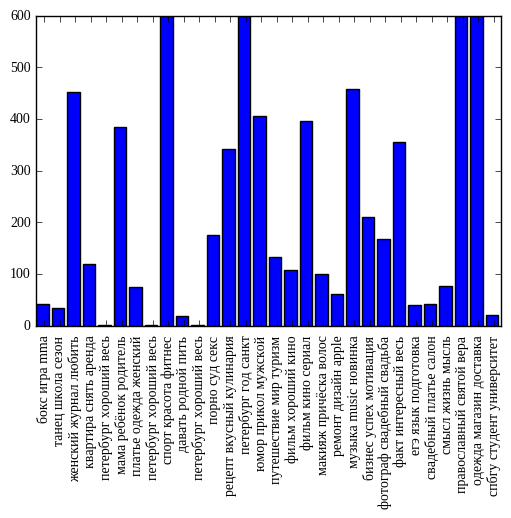


Topics in Bayesian Gaussian Mixture model:
Topic #0:
бокс игра mma бой russia world news уличный top best
Topic #1:
танец школа сезон танцевать dance topic family танцевальный уличный studio
Topic #2:
женский журнал любить красота девушка любовь секрет счастие мысль жизнь
Topic #3:
квартира снять аренда сдать петербург хотеть агент санкт посредник комната
Topic #4:
петербург хороший весь жизнь санкт одежда мир год человек россия
Topic #5:
мама ребёнок родитель семья читать голос вязание конкурс детка найти
Topic #6:
платье одежда женский часы модный вечерний мода магазин обувь туфля
Topic #7:
петербург хороший весь жизнь санкт одежда мир год человек россия
Topic #8:
спорт красота фитнес спортивный прогноз девушка футбол здоровье жизнь питание
Topic #9:
давать родной пить hip hop свидание верить человек посмотреть окружающий
Topic #10:
петербург хороший весь жизнь санкт одежда мир год человек россия
Topic #11:
порно суд секс районный федерация основание территория решение данный россий

In [91]:
def create_topic_vector(model_components, feature_names, n_topics, n_top_words):
    #topics = np.chararray((n_topics), itemsize=50)#.encode('utf-8')
    topics=[]
    for topic_idx, topic in enumerate(model_components):
        tmp=u""
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            tmp += (feature_names[i] + u" ")
        topics.append(tmp)
    return topics

def plot_topic_dist(data, topics):
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('font',**{'family': 'Liberation Serif', 'weight': 'normal'})

    plt.bar(np.arange(len(topics)), data)
    plt.xticks(np.arange(len(topics))+0.5, topics, rotation='vertical')
    plt.ylim((0.0, 600))
    plt.show()
    
    return



topic_names = create_topic_vector(gaus.means_, tfidf_feature_names, n_topics, 3)

n_top_words = 10


plot_topic_dist(gaus.mean_precision_, topic_names)


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.means_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
print("\nTopics in Bayesian Gaussian Mixture model:")
print_top_words(gaus, tfidf_feature_names, n_top_words)

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 2500
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=n_features, analyzer='word', tokenizer = russian_vk)
tf = tf_vectorizer.fit_transform( get_group_doc(group_data) )


Extracting tf features for LDA...


In [85]:
#tmp = np.asarray(group_data_tmp['description'].loc[1]).view(np.chararray)
#print (group_data_tmp['description'].loc[1], itemsize=20) )
#print (group_data_tmp['description'].loc[3])
#tfidf = tfidf_vectorizer.fit_transform(group_data['description'].loc[3])


# Fit the NMF model
print("Fitting the NMF model with tf-idf features, " \
      "n_samples=%d and n_features=%d..." \
      % (n_samples, n_features))

n_topics = 30


nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

Fitting the NMF model with tf-idf features, n_samples=20000 and n_features=2500...

Topics in NMF model:


In [86]:
n_top_words = 10
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
одежда магазин детский заказ доставка интернет обувь товар модный наличие
Topic #1:
год человек весь друг работа новость вопрос хотеть мочь день
Topic #2:
петербург санкт питер город событие афиша spb работа район москва
Topic #3:
фильм кино новинка смотреть кинотеатр мультфильм ужас новое посмотреть качество
Topic #4:
порно секс видео знакомство русский домашний эротика суд фото девушка
Topic #5:
фотограф свадебный свадьба фотография фотосессия съёмка фото фотосъёмка семейный москва
Topic #6:
музыка music новинка клубный музыкальный рок новый машина скачать клип
Topic #7:
рецепт вкусный кулинария кулинарный блюдо готовить кухня простой диета еда
Topic #8:
женский секрет журнал женщина одежда счастие совет психология хитрость полезный
Topic #9:
игра приложение игровой игрок играть game games престол компьютерный app
Topic #10:
хороший настроение день видео цитата фото статус сеть best девочка
Topic #11:
жизнь хитрость человек образ философия психология здоровый life смысл ист

Найденные темы:

n_topics = 30 : одежда, фильмы, События в Питере, Свадебный фотограф, Порно, Игры, Гороскоп, Кулинария, Музыка, Новости, Женский паблик, сериалы, 12?, 13?, Знакомства, Недвижимость, Юмор, 17 - Цитатник?, 18?, Дети и Семья, Фото девушек, Путешествия, Бизнес, 23 еще одна музыка?, Интеренет шоппинг, Россия, Мужкой паблик, 27 еще один юмор?, Красота (макияж и ресницы), Спорт
Из 30 тем 24 четко выражены.

n_topics = 25 : одежда, фильмы, Свадебный фотограф, Порно, музыка, россия, Игры, События в Питере, Гороскоп, Кулинария, Музыка, Новости, Женский паблик, сериалы, 12?, 13?, Знакомства, Недвижимость, Юмор, 17 - Цитатник?, 18?, Дети и Семья, Фото девушек, Путешествия, Бизнес, 23 еще одна музыка? (eng), Интеренет шоппинг, Россия, Мужкой паблик, 27 еще один юмор?, Красота (макияж и ресницы), Спорт




In [473]:
print("Fitting LDA models with tf features, " \
      "n_samples=%d and n_features=%d..." \
      % (n_samples, n_features))

n_topics = 25
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=10, n_jobs=-1, learning_decay = 0.9, \
                     batch_size = 200,  learning_method='online', learning_offset=50., random_state=0)

words_in_topics = lda.fit(tf)

new_score = lda.score(tf)
print (n_topics, new_score, new_score - old_score )
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)
old_score = new_score

#n_features=1000 is not enought

Fitting LDA models with tf features, n_samples=20000 and n_features=2500...
25 -3619493.59594 10677.9139027

Topics in LDA model:
Topic #0:
волос школа наращивание макияж студия мастер обучение причёска работа курс
Topic #1:
фильм кино сериал хороший сезон татуировка серия тат смотреть новинка
Topic #2:
человек жизнь год мир история весь стать время делать жить
Topic #3:
психология душа отношение философия саморазвитие бог владимир стих эзотерика православный
Topic #4:
язык английский english французский немецкий слово итальянский воздушный шар перевод
Topic #5:
искусство граффити арт книга культура издание художник art животное год
Topic #6:
мир уличный мода новость стиль спорт фитнес событие fashion love
Topic #7:
рок александр гитара сергей rock понять вокал голос дмитрий андрей
Topic #8:
world russia сумка кожа натуральный продукт брат браслет камень сервер
Topic #9:
год являться материал право цель проект российский международный лицо авторский
Topic #10:
россия танец страна dance

In [337]:
#print (lda.components_.shape)
#print (topics_in_group.shape)
#print (lda.components_[0])



#print (pd.DataFrame(group_data.loc[0]).T)


#For predifined word_topic_dist
def get_topic_dist(words, components, n_features):
    
    from sklearn.decomposition._online_lda import mean_change, _dirichlet_expectation_1d
    EPS = np.finfo(np.float).eps
    list_of_topic_words=np.zeros((len(words)), dtype=int)
    list_words_counts  =np.zeros(n_features, dtype=int)

    k=0
    for i,w in enumerate(words):
        for j,x in enumerate(tf_feature_names):
            if (w == x):
                if (list_words_counts[j] == 0):
                    list_of_topic_words[k] = j
                    k+=1
                list_words_counts[j]+=1
                break

    list_of_topic_words = np.trim_zeros(list_of_topic_words)        
    doc_topic_d = np.ones(n_topics)
    exp_doc_topic_d = np.zeros(n_topics)
    exp_topic_word_d = components[:,list_of_topic_words].copy() # lda.components_[:,list_of_topic_words].copy()
    tf_vector = list_words_counts[list_of_topic_words]


    # Iterate between `doc_topic_d` and `norm_phi` until convergence
    for i in range(0, 20):
        last_d = doc_topic_d

        # The optimal phi_{dwk} is proportional to
        # exp(E[log(theta_{dk})]) * exp(E[log(beta_{dw})]).
        norm_phi = np.dot(exp_doc_topic_d, exp_topic_word_d) + EPS

        doc_topic_d = (exp_doc_topic_d *
        np.dot(tf_vector / norm_phi, exp_topic_word_d.T))
        # Note: adds doc_topic_prior to doc_topic_d, in-place.
        _dirichlet_expectation_1d(doc_topic_d, 1./n_topics, exp_doc_topic_d)

        if mean_change(last_d, doc_topic_d) < 0.001:
                    break
    
    return doc_topic_d/doc_topic_d.sum()


topics = get_topic_dist(words, lda.components_, n_features)

#sum of all group vectors
user_pref = get_topic_dist(words, lda.components_, n_features)

print (topics)
#print (exp_doc_topic_d)
print (topics_in_group[0])



[ 0.00137931  0.00137931  0.00137931  0.00137931  0.00137931  0.00137931
  0.00137931  0.00137931  0.00137931  0.00137931  0.00137931  0.00137931
  0.00137931  0.00137931  0.23836829  0.40533236  0.00137931  0.00137931
  0.00137931  0.29248585  0.00137931  0.00137931  0.03484798  0.00137931
  0.00137931]
[  0.04         0.04         0.04         0.04         0.04         0.04
   0.04         0.04         0.04         0.04         0.04         0.04
   0.04         0.04         6.81357854  12.54309235   0.04         0.04
   0.04         7.76036223   0.04         0.04         1.04296688   0.04
   0.04      ]


In [320]:
topics_in_group = lda.transform(tf)
print (topics_in_group[0])
print (group_data['description'].loc[0])


[  0.04         0.04         0.04         0.04         0.04         0.04
   0.04         0.04         0.04         0.04         0.04         0.04
   0.04         0.04         6.81357854  12.54309235   0.04         0.04
   0.04         7.76036223   0.04         0.04         1.04296688   0.04
   0.04      ]
«Blog Fiesta» — для людей, интересующихся событиями Петербурга и всем, что связано с городом. Мы ищем необычные, интересные мероприятия, делимся фотографиями и рассказываем о неформальных достопримечательностях города.


In [193]:
def get_groups_from_user(user_id):
    params = up.urlencode({'user_id': user_id})
    url="https://api.vk.com/method/users.getSubscriptions?%s" % params
    response = ur.urlopen(url)
    group_ids = response.read().decode('utf-8')
    group_ids = json.loads(group_ids)['response']
    res={'id': user_id, 'groups': ''}
    #print (group_ids[])
   
    try:
        if ( group_ids['groups']['count'] > 0):
            return group_ids['groups']['items']
    except:
        pass
    return res
    
#get_groups_from_user(1012451)

In [395]:
def describe_user_pref(user_id, model, n_features, n_topics):
    group_list = get_groups_from_user(user_id)
    topics = np.zeros(n_topics)
    for group_id in group_list:
        group_info = pd.DataFrame({"id": groip_id}, columns=['id', 'name', 'status', 'description'])
        group_info = pd.DataFrame.from_dict(get_description(group_id), orient='index').T
        words = get_group_doc(group_info).loc[0]
        #print (group_info['name'])
        words = russian_vk(words)
        topics += get_topic_dist(words, model.components_, n_features)
    return topics/len(group_list)
    
    
user_pref = describe_user_pref(1012451, lda, n_features, n_topics)


    

In [443]:
def create_topic_vector(model, feature_names, n_topics, n_top_words):
    #topics = np.chararray((n_topics), itemsize=50)#.encode('utf-8')
    topics=[]
    for topic_idx, topic in enumerate(model.components_):
        tmp=u""
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            #print (feature_names[i])
            tmp += (feature_names[i] + u" ")
        topics.append(tmp)
    return topics

topic_names = create_topic_vector(lda, tf_feature_names, n_topics, 3)


print (topic_names)
    
    
print (user_pref)
print (tf_feature_names[16])
print (user_pref.argsort())
#for topic_idx, val in enumerate(user_pref):
#    print("Topic #%d:" % topic_idx)
#    print(" ".join([tf_feature_names[i]
#                        for i in user_pref.argsort()[:-3 - 1:-1]]))
#    print()

['одежда магазин заказ ', 'фильм кино сериал ', 'жизнь человек любовь ', 'искусство подарок психология ', 'порно русский видео ', 'гороскоп татуировка тат ', 'идея книга мастер ', 'рок душа прикол ', 'музыка студия танец ', 'год секс сезон ', 'время сила мысль ', 'фотограф игра свадьба ', 'ребёнок детский рецепт ', 'волос женский школа ', 'город курс мероприятие ', 'мир хороший интересный ', 'правило реклама вопрос ', 'любитель техника цвета ', 'друг хотеть тур ', 'петербург санкт работа ', 'спорт спортивный торт ', 'история бизнес факт ', 'стиль мода мужской ', 'дом девушка полезный ', 'мама современный подписаться ']
[ 0.00840419  0.07166993  0.04497846  0.00465534  0.04444245  0.00389215
  0.07400731  0.00286007  0.00618841  0.00836659  0.07043141  0.03293858
  0.06068435  0.18859089  0.00649193  0.05387918  0.08849942  0.01733969
  0.04000727  0.04879708  0.00286007  0.06659995  0.00506569  0.03009448
  0.0182551 ]
bass
[20  7  5  3 22  8 14  9  0 17 24 23 11 18  4  2 19 15 12 21 1

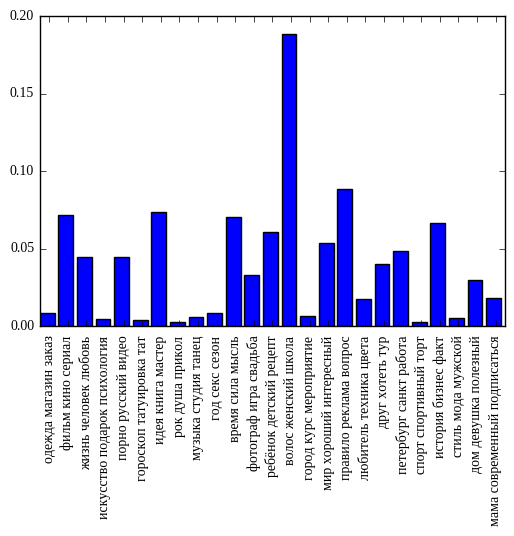

In [454]:
#%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family': 'Liberation Serif', 'weight': 'normal'})

plt.bar(np.arange(n_topics), user_pref)
plt.xticks(np.arange(n_topics)+0.5, topic_names, rotation='vertical')
plt.show()